<h3>Q2. Given the following dataset (First tokenize based on punctuations and lower case all the
sentences):<br>
<p>The boy hugs the cat.<br>
The boys are hugging the dogs.<br>
The dogs are chasing the cats.<br>
The dog and the cat sit quietly.<br>
The boy is sitting on the dog.<br>
Apply the wordpiece algorithm to find the vocabulary of tokens. Apply the merge step for 20
iterations. How will the following sentence be tokenized according to the wordpiece based on
the vocabulary you got from the dataset.
The cat is chasing the dog quietly.</p>

In [1]:
import collections
import re

def prepare_corpus(dataset):
    """Tokenizes text, counts word frequencies, and formats for WordPiece."""
    word_freqs = collections.defaultdict(int)
    for sentence in dataset:
        words = re.findall(r"[\w']+|[.,!?;]", sentence.lower())
        for word in words:
            word_freqs[word] += 1
    
    corpus = collections.defaultdict(int)
    for word, freq in word_freqs.items():
        corpus[' '.join(list(word)) + ' </w>'] = freq
    return corpus

# --- Step 2: Core WordPiece Functions ---

def get_pair_stats(corpus):
    """Counts the frequency of each adjacent pair of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in corpus.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_pair(best_pair, corpus):
    """Merges the best pair into a single new token throughout the corpus."""
    new_corpus = collections.defaultdict(int)
    pair_str = ' '.join(best_pair)
    # The merged token (e.g., 'th')
    new_token = ''.join(best_pair)
    
    for word, freq in corpus.items():
        # Replace all occurrences of the pair with the new token
        new_word = word.replace(pair_str, new_token)
        new_corpus[new_word] = freq
    return new_corpus

# --- Step 3: Tokenize New Words ---

def tokenize(word, vocab):
    word = word + '</w>'
    
    tokens = []
    while word:
        # We check from longest to shortest to ensure a greedy match
        found = False
        for i in range(len(word), 0, -1):
            subword = word[:i]
            if subword in vocab:
                tokens.append(subword)
                word = word[i:] 
                found = True
                break
        if not found:
            print(f"Error: Cannot tokenize '{word}'")
            break
            
    return tokens

dataset = [
    "The boy hugs the cat.",
    "The boys are hugging the dogs.",
    "The dogs are chasing the cats.",
    "The dog and the cat sit quietly.",
    "The boy is sitting on the dog."
]

corpus = prepare_corpus(dataset)

# 2. Initialize vocabulary with base characters
vocab = set()
for word in corpus:
    vocab.update(word.split())

print("--- Starting Merges ---")
for i in range(20):
    pairs = get_pair_stats(corpus)
    if not pairs:
        break
    
    best_pair = max(pairs, key=pairs.get)
    
    # Merge the best pair in our corpus
    corpus = merge_pair(best_pair, corpus)
    
    new_token = ''.join(best_pair)
    vocab.add(new_token)
    
    print(f"Iteration {i+1}: Merged {best_pair} -> '{new_token}'")

print("\n--- Final Vocabulary (sample) ---")
print(sorted(list(vocab))[:])

new_sentence = "The cat is chasing the dog quietly."
print(f"\n--- Tokenizing: '{new_sentence}' ---")

words = re.findall(r"[\w']+|[.,!?;]", new_sentence.lower())

final_tokens = []
for word in words:
    word_tokens = tokenize(word, vocab)
    final_tokens.extend(word_tokens)

print("\nFinal Tokenized Output:")
print(final_tokens)

--- Starting Merges ---
Iteration 1: Merged ('e', '</w>') -> 'e</w>'
Iteration 2: Merged ('t', 'h') -> 'th'
Iteration 3: Merged ('th', 'e</w>') -> 'the</w>'
Iteration 4: Merged ('s', '</w>') -> 's</w>'
Iteration 5: Merged ('.', '</w>') -> '.</w>'
Iteration 6: Merged ('g', '</w>') -> 'g</w>'
Iteration 7: Merged ('d', 'o') -> 'do'
Iteration 8: Merged ('b', 'o') -> 'bo'
Iteration 9: Merged ('bo', 'y') -> 'boy'
Iteration 10: Merged ('g', 's</w>') -> 'gs</w>'
Iteration 11: Merged ('c', 'a') -> 'ca'
Iteration 12: Merged ('ca', 't') -> 'cat'
Iteration 13: Merged ('i', 'n') -> 'in'
Iteration 14: Merged ('in', 'g</w>') -> 'ing</w>'
Iteration 15: Merged ('boy', '</w>') -> 'boy</w>'
Iteration 16: Merged ('h', 'u') -> 'hu'
Iteration 17: Merged ('cat', '</w>') -> 'cat</w>'
Iteration 18: Merged ('a', 'r') -> 'ar'
Iteration 19: Merged ('ar', 'e</w>') -> 'are</w>'
Iteration 20: Merged ('do', 'gs</w>') -> 'dogs</w>'

--- Final Vocabulary (sample) ---
['.', '.</w>', '</w>', 'a', 'ar', 'are</w>', 'b', 'b

<h3>3. The following table represents the sentences and corresponding labels in a sentence
classification task constituting the training data for the task:<br>

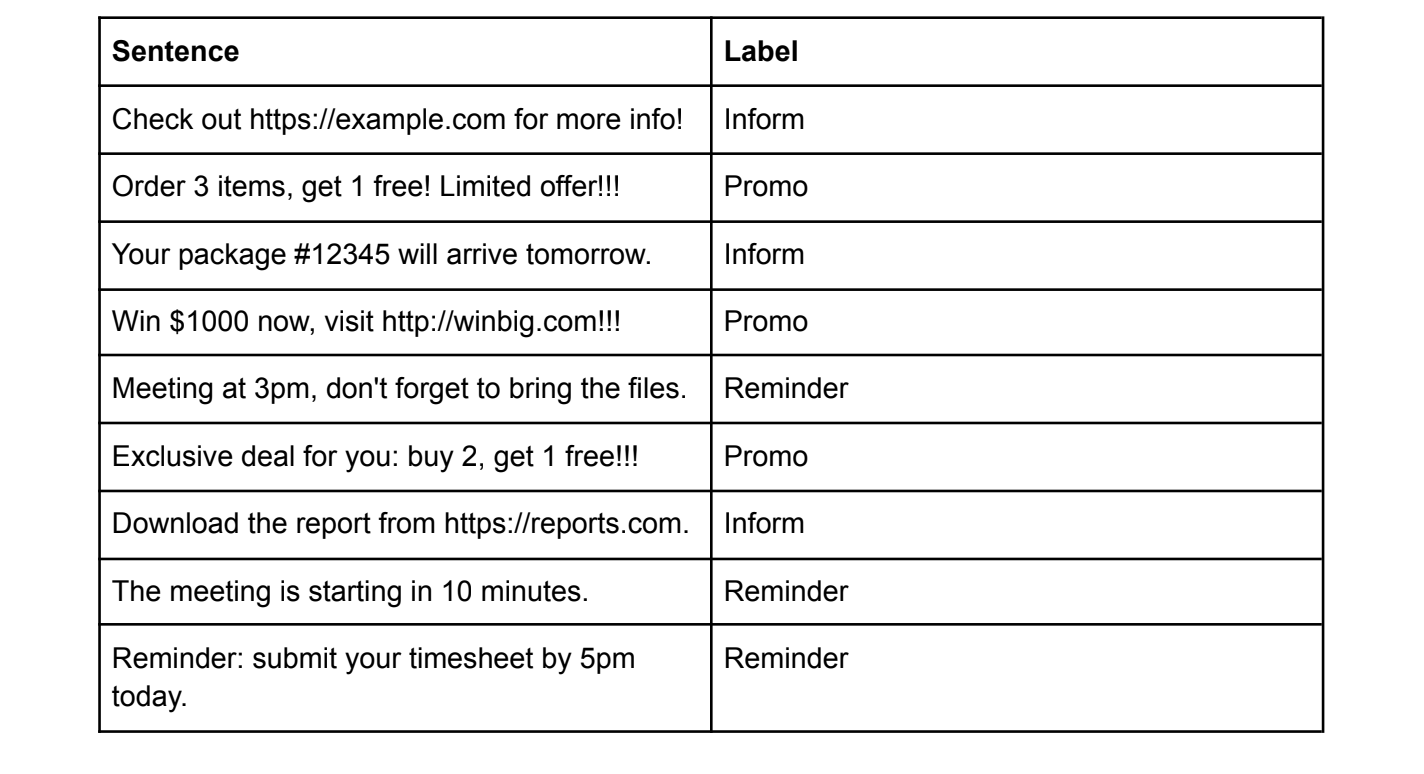<br>
<p>Design specific features that define a class/label very well. [Hint: Use binary/frequency based
features for presence of URLs, Numbers, and Punctuations] Use bag-of-words representation
for bigrams appearing in a sentence and use probability of bigrams with add-K smoothing
(where K=0.3) as features. Apply the same preprocessing techniques that you used in Question
1 and write all sentences after preprocessing. Find all features and their corresponding
probabilities for a Naive Bayes’ classifier. Predict the label for the following sentence using the
Naive Bayes’ classification algorithm:
You will get an exclusive offer in the meeting!</p>

In [ ]:
import re
import collections
import math

train_data = [
    ("Check out https://example.com for more info!", "Inform"),
    ("Order 3 items, get 1 free! Limited offer!!!", "Promo"),
    ("Your package #12345 will arrive tomorrow.", "Inform"),
    ("Win $1000 now, visit http://winbig.com!!!", "Promo"),
    ("Meeting at 3pm, don't forget to bring the files.", "Reminder"),
    ("Exclusive deal for you: buy 2, get 1 free!!!", "Promo"),
    ("Download the report from https://reports.com.", "Inform"),
    ("The meeting is starting in 10 minutes.", "Reminder"),
    ("Reminder: submit your timesheet by 5pm today.", "Reminder"),
]
new_sentence = "You will get an exclusive offer in the meeting!"
K = 0.3

def preprocess(sentence):
    text = sentence.lower()
    text = re.sub(r'https?://\S+', 'URL', text)
    text = re.sub(r'[\$#]?\d+(\.\d+)?', 'NUMBER', text)
    # Add spaces around punctuation so they can be split correctly
    text = re.sub(r'([!.,?:]+)', r' \1 ', text)
    text = re.sub(r'[!.,?:]', 'PUNCT', text)
    return text.split()

class_bigrams = collections.defaultdict(list)
all_bigrams = set()

for sentence, label in train_data:
    tokens = preprocess(sentence)
    bigrams = list(zip(tokens, tokens[1:]))
    class_bigrams[label].extend(bigrams)
    all_bigrams.update(bigrams)

V_bigram = len(all_bigrams)  #number of unique bigrams

# 4.Prediction: Calculate Scores for the New Sentence 
scores = {}
new_tokens = preprocess(new_sentence)
new_bigrams = list(zip(new_tokens, new_tokens[1:]))

for label in ["Inform", "Promo", "Reminder"]:
    # P(Class) = (sentences in class) / (total sentences)
    prior = len(class_bigrams[label]) / len(train_data)
    score = math.log(prior)

    # b. Calculate likelihoods P(Bigram | Class) for each bigram in the new sentence
    total_bigrams_in_class = len(class_bigrams[label])
    bigram_counts_in_class = collections.Counter(class_bigrams[label])

    # The denominator for our smoothing formula
    denominator = total_bigrams_in_class + K * V_bigram

    for bg in new_bigrams:
        # P(bigram|Class) = (count(bg in class) + K) / (total bigrams in class + K * V)
        count = bigram_counts_in_class[bg]
        probability = (count + K) / denominator
        score += math.log(probability)

    scores[label] = score

prediction = max(scores, key=scores.get)

print(f"Sentence: '{new_sentence}'")
print(f"Processed: {' '.join(new_tokens)}")
print("\n--- Log-Probability Scores ---")
for label, score in sorted(scores.items(), key=lambda item: item[1], reverse=True):
    print(f"  - {label:<10}: {score:.2f}")

print(f"\n✅ Predicted Label: {prediction}")

Sentence: 'You will get an exclusive offer in the meeting!'
Processed: you will get an exclusive offer in the meeting PUNCT

--- Log-Probability Scores ---
  - Inform    : -42.31
  - Reminder  : -42.45
  - Promo     : -44.07

✅ Predicted Label: Inform
